<h2>Introduction</h2>


In this noteboook I build two Neural Networks capable to perform handwritten digits classification. The first Network is a simple Multi-layer Perceptron (MLP) and the second one is a Convolutional Neural Network (CNN). In other words, when given an input our algorithm will say, with some associated error, what type of digit this input represents.

* * *


<h2>Installing TensorFlow </h2>

We begin by installing TensorFlow version 2.2.0 and its required prerequistes. 


In [1]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

     |████████████████████████████████| 2.2 MB 8.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
     |████████████████████████████████| 516.2 MB 4.0 kB/s 
     |████████████████████████████████| 454 kB 53.6 MB/s 
     |████████████████████████████████| 3.0 MB 46.4 MB/s 
     |████████████████████████████████| 2.9 MB 50.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
  

<b>Notice:</b> This notebook has been created with TensorFlow version 2.2, and might not work with other versions. Therefore we check:


In [2]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if not tf.__version__ == '2.2.0':
    printmd('<<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.2.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>>')

<h3>Import the MNIST dataset using TensorFlow built-in feature</h3>


It's very important to notice that MNIST is a high optimized data-set and it does not contain images. We need to build our own code if we want to see the real digits.

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


The features data are between 0 and 255, and need to normalize this to improve optimization performance.


In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's take a look at the first few label values: 


In [5]:
print(y_train[0:5])

[5 0 4 1 9]


The current label scheme simply identifies the category to which each data point belongs (each handwritten digit is assigned a category equal to the number value). I am going to convert this into a one-hot encoded vector.  In contrast to Binary representation, the labels will be presented in a way that to represent a number N, the $N^{th}$ bit is 1 while the the other bits are 0. For example, five and zero in a binary code would be:


<pre>
Number representation:    0
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       0       0       0 

Number representation:    5
Binary encoding:        [2^5]  [2^4]   [2^3]   [2^2]   [2^1]   [2^0]  
Array/vector:             0      0       0       1       0       1  
</pre>


Using a different notation, the same digits using one-hot vector representation can be show as: 


<pre>
Number representation:    0
One-hot encoding:        [5]   [4]    [3]    [2]    [1]   [0]  
Array/vector:             0     0      0      0      0     1   

Number representation:    5
One-hot encoding:        [5]   [4]    [3]    [2]    [1]    [0]  
Array/vector:             1     0      0      0      0      0   
</pre>


In [6]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [7]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

<h3>Converting a 2D Image into a 1D Vector</h3>


MNIST images are black and white thumbnail square images with 28x28 pixels.  Each pixel is assigned an intensity (originally on a scale of 0 to 255).  To make the input useful to us, we need these to be arranged in a 1D vector using a consistent strategy, as is shown in the figure below.  We can use `Flatten` to accomplish this task.


In [9]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


<h3>Assigning bias and weights to null tensors</h3>


Now I am going to create the weights and biases, for this purpose they will be used as arrays filled with zeros. The values that we choose here can be critical, but we'll cover a better way on the second part, instead of this type of initialization.
Since these values will be adjusted during the optimization process, we define them using  `tf.Variable`.

NOTE:  `tf.Variable` creates adjustable variables that are in the global namespace, so any function that references these variables need not pass the varibles.  But they are globals, so exercise caution when naming!


In [10]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

<h3>Adding Weights and Biases to input</h3>


In [11]:
def forward(x):
    return tf.matmul(x,W) + b

<h3>Softmax Regression</h3>


In [12]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


Now define our output layer


In [13]:
def activate(x):
    return tf.nn.softmax(forward(x))

Let's create a `model` function for convenience.


In [14]:
def model(x):
    x = flatten(x)
    return activate(x)

<h3>Cost function</h3>


In [15]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.0

<h3>Type of optimization: Gradient Descent</h3>


In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

Now we define the training step.  This step uses `GradientTape` to automatically compute deriviatives of the functions we have manually created and applies them using the `SGD` optimizer. 


In [17]:
def train_step(x, y ):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

<h3>Training batches</h3>


In [18]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 


epoch  0 batch 500 loss: 177.26141
epoch  0 batch 1000 loss: 174.39491
end of epoch  0 loss 223471.0 accuracy 0.8147
epoch  1 batch 500 loss: 153.2364
epoch  1 batch 1000 loss: 178.1075
end of epoch  1 loss 216641.61 accuracy 0.824
epoch  2 batch 500 loss: 209.28334
epoch  2 batch 1000 loss: 172.85431
end of epoch  2 loss 207265.33 accuracy 0.83315
epoch  3 batch 500 loss: 203.7942
epoch  3 batch 1000 loss: 152.35666
end of epoch  3 loss 210062.88 accuracy 0.8303
epoch  4 batch 500 loss: 189.21526
epoch  4 batch 1000 loss: 163.97006
end of epoch  4 loss 211364.31 accuracy 0.82985
epoch  5 batch 500 loss: 215.90894
epoch  5 batch 1000 loss: 175.0403
end of epoch  5 loss 202569.7 accuracy 0.83845
epoch  6 batch 500 loss: 200.97389
epoch  6 batch 1000 loss: 167.53844
end of epoch  6 loss 207683.56 accuracy 0.83435
epoch  7 batch 500 loss: 200.98653
epoch  7 batch 1000 loss: 185.46494
end of epoch  7 loss 200680.2 accuracy 0.8413333
epoch  8 batch 500 loss: 213.95403
epoch  8 batch 1000 lo

<h3>Test and Plots</h3>


In [19]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84305
test accuracy 0.8355


<hr>


The next two plots show the performance of the optimization at each epoch.


Text(0, 0.5, 'loss')

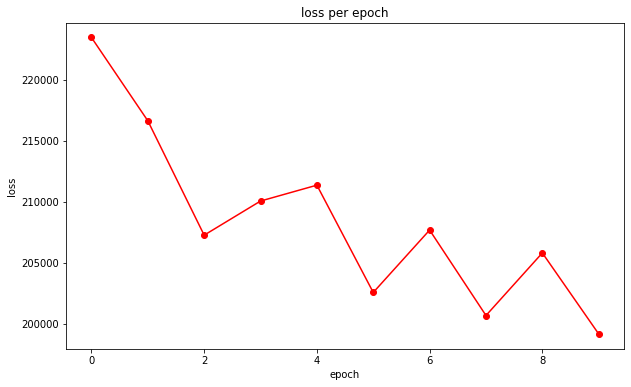

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

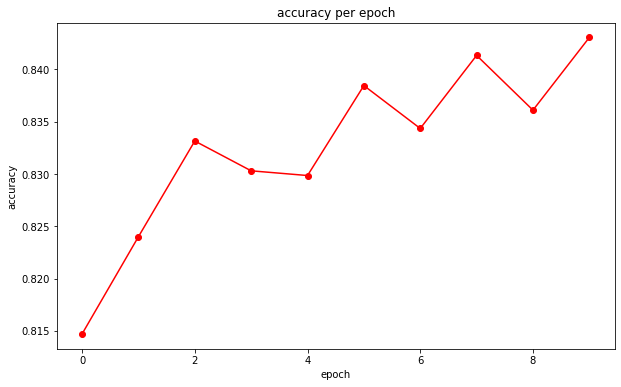

In [21]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

<a id="ref4"></a>

<h2>Evaluating the final result</h2>


84% accuracy is not bad considering the simplicity of the model, but >90% accuracy has been achieved in the past.  


<a id="ref5"></a>

<h2>How to improve our model?</h2>


<h4>Several options as follow:</h4>
<ul>
    <li>Regularization of Neural Networks using DropConnect</li>
    <li>Multi-column Deep Neural Networks for Image Classification</li> 
    <li>APAC: Augmented Pattern Classification with Neural Networks</li>
    <li>Simple Deep Neural Network with Dropout</li>
</ul>
<h4>In the next part we are going to explore the option:</h4>
<ul>
    <li>Simple Deep Neural Network with Dropout (more than 1 hidden layer)</li>
</ul> 


<hr>


<a id="ref6"></a>

<h2>2nd part: Deep Learning applied on MNIST</h2>


In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network. 

Architecture of our network is:

-   (Input) -> [batch_size, 28, 28, 1]  >> Apply 32 filter of [5x5]
-   (Convolutional layer 1)  -> [batch_size, 28, 28, 32]
-   (ReLU 1)  -> [?, 28, 28, 32]
-   (Max pooling 1) -> [?, 14, 14, 32]
-   (Convolutional layer 2)  -> [?, 14, 14, 64] 
-   (ReLU 2)  -> [?, 14, 14, 64] 
-   (Max pooling 2)  -> [?, 7, 7, 64] 
-   [fully connected layer 3] -> [1x1024]
-   [ReLU 3]  -> [1x1024]
-   [Drop out]  -> [1x1024]
-   [fully connected layer 4] -> [1x10]

The next cells will explore this new architecture.


<h3>The MNIST data</h3>


The MNIST Dataset will be used from the above example.


<h3>Initial parameters</h3>


Create general parameters for the model


In [22]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

<h4>Converting images of the data set to tensors</h4>


The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the <b>batch number</b> of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.


In [23]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [24]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

<h3>Convolutional Layer 1</h3>


<h4>Defining kernel weight and bias</h4>
We define a kernel here. The Size of the filter/kernel is 5x5;  Input channels is 1 (grayscale);  and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape <code>[filter_height, filter_width, in_channels, out_channels]</code>


In [25]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [26]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

<h4>Apply the ReLU activation Function</h4>


In [27]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

<h4>Apply the max pooling</h4>


In [28]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

First layer completed


<h3>Convolutional Layer 2</h3>
<h4>Weights and Biases of kernels</h4>


In [29]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

<h4>Convolve image with weight tensor and add biases.</h4>


In [30]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

<h4>Apply the ReLU activation Function</h4>


In [31]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

<h4>Apply the max pooling</h4>


In [32]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

Second layer completed. So, what is the output of the second layer, layer2?

-   it is 64 matrix of [7x7]


<h3>Fully Connected Layer</h3>


<h4>Flattening Second Layer</h4>


In [33]:
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

<h4>Weights and Biases between layer 2 and 3</h4>


Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer


In [34]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [35]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

<h4>Apply the ReLU activation Function</h4>


In [36]:
def h_fc1(x): return tf.nn.relu(fcl(x))

Third layer completed


<h4>Dropout Layer, Optional phase for reducing overfitting</h4>


In [37]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

<h4>Readout Layer (Softmax Layer)</h4>


Type: Softmax, Fully Connected Layer.


<h4>Weights and Biases</h4>


In last layer, CNN takes the high-level filtered images and translate them into votes using softmax.
Input channels: 1024 (neurons from the 3rd Layer); 10 output features


In [38]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

<h4>Matrix Multiplication (applying weights and biases)</h4>


In [39]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

<h4>Apply the Softmax activation Function</h4>
<b>softmax</b> allows us to interpret the outputs of <b>fcl4</b> as probabilities. So, <b>y_conv</b> is a tensor of probabilities.


In [40]:
def y_CNN(x): return tf.nn.softmax(fc(x))

* * *


<a id="ref7"></a>

<h2>Summary of the Deep Convolutional Neural Network</h2>


Now is time to remember the structure of  our network


#### 0) Input - MNIST dataset

#### 1) Convolutional and Max-Pooling

#### 2) Convolutional and Max-Pooling

#### 3) Fully Connected Layer

#### 4) Processing - Dropout

#### 5) Readout layer - Fully Connected

#### 6) Outputs - Classified digits


* * *


<a id="ref8"></a>

<h2>Define functions and train the model</h2>


In [41]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

<h4>Define the optimizer</h4>



In [42]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Following the convention of our first example, we will use `GradientTape` to define a model.


In [43]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()


In [44]:
"""results = []
increment = 1000
for start in range(0,60000,increment):
    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])
    t = y_CNN(s)
    #results.append(t)
"""

'results = []\nincrement = 1000\nfor start in range(0,60000,increment):\n    s = tf.slice(x_image_train,[start,0,0,0],[start+increment-1, 28, 28, 1])\n    t = y_CNN(s)\n    #results.append(t)\n'

<h4>Define prediction</h4>
Do you want to know how many of the cases in a mini-batch has been classified correctly? lets count them.


In [45]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

<h4>Define accuracy</h4>
It makes more sense to report accuracy using average of correct cases.


In [46]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

<h4>Run session, train</h4>


In [47]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 126.08419 accuracy 0.36
epoch  0 batch 100 loss: 64.510956 accuracy 0.68
epoch  0 batch 150 loss: 48.51139 accuracy 0.76
epoch  0 batch 200 loss: 26.950418 accuracy 0.86
epoch  0 batch 250 loss: 32.700115 accuracy 0.76
epoch  0 batch 300 loss: 20.87161 accuracy 0.8
epoch  0 batch 350 loss: 28.514294 accuracy 0.84
epoch  0 batch 400 loss: 19.829475 accuracy 0.82
epoch  0 batch 450 loss: 26.188229 accuracy 0.82
epoch  0 batch 500 loss: 10.270775 accuracy 0.98
epoch  0 batch 550 loss: 23.800163 accuracy 0.86
epoch  0 batch 600 loss: 15.592822 accuracy 0.88
epoch  0 batch 650 loss: 19.672901 accuracy 0.88
epoch  0 batch 700 loss: 8.281889 accuracy 0.96
epoch  0 batch 750 loss: 22.674158 accuracy 0.82
epoch  0 batch 800 loss: 14.375456 accuracy 0.86
epoch  0 batch 850 loss: 16.353222 accuracy 0.94
epoch  0 batch 900 loss: 20.028679 accuracy 0.9
epoch  0 batch 950 loss: 13.631198 accuracy 0.92
epoch  0 batch 1000 loss: 6.980438 accuracy 0.9
epoch  0 batch 1050 loss: 3


<font size = 3><strong><i>95% accuracy after only 1 epoch!  </i></strong></font>


<hr>


<a id="ref9"></a>

<h2>Evaluate the model</h2>


Print the evaluation to the user


In [48]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))            

batch 100 accuracy 0.92
batch 200 accuracy 1.0
batch 300 accuracy 0.92
batch 400 accuracy 1.0
batch 500 accuracy 0.94
batch 600 accuracy 0.9
batch 700 accuracy 1.0
batch 800 accuracy 0.94
batch 900 accuracy 0.92
batch 1000 accuracy 0.98
batch 1100 accuracy 0.92
batch 1200 accuracy 0.96
accuracy of entire set 0.9426


<h3>Visualization</h3>


Do you want to look at all the filters?


In [49]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

--2022-01-17 07:23:55--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2022-01-17 07:23:55 (562 MB/s) - ‘utils1.py’ saved [5097/5097]



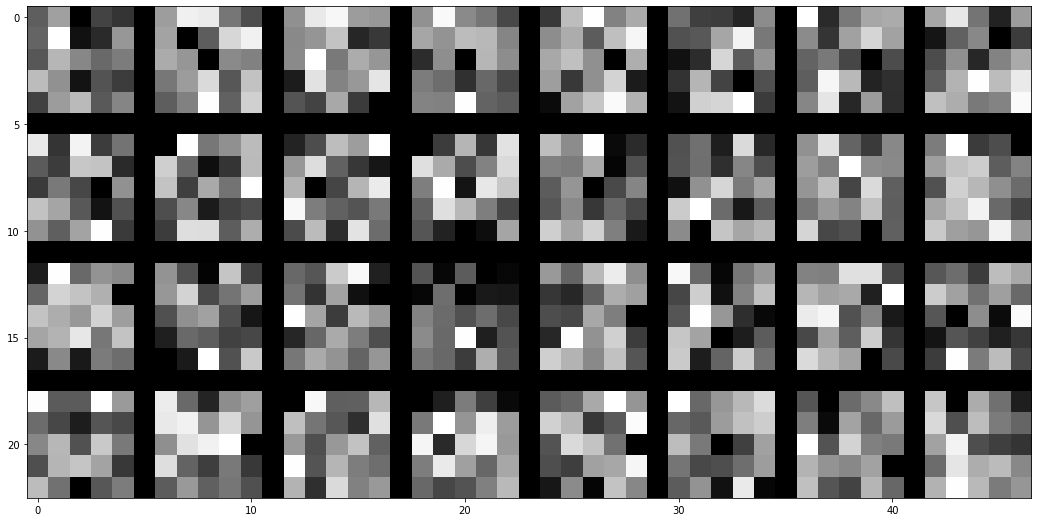

In [50]:
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Do you want to see the output of an image passing through first convolution layer?


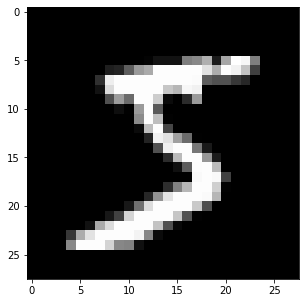

In [51]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

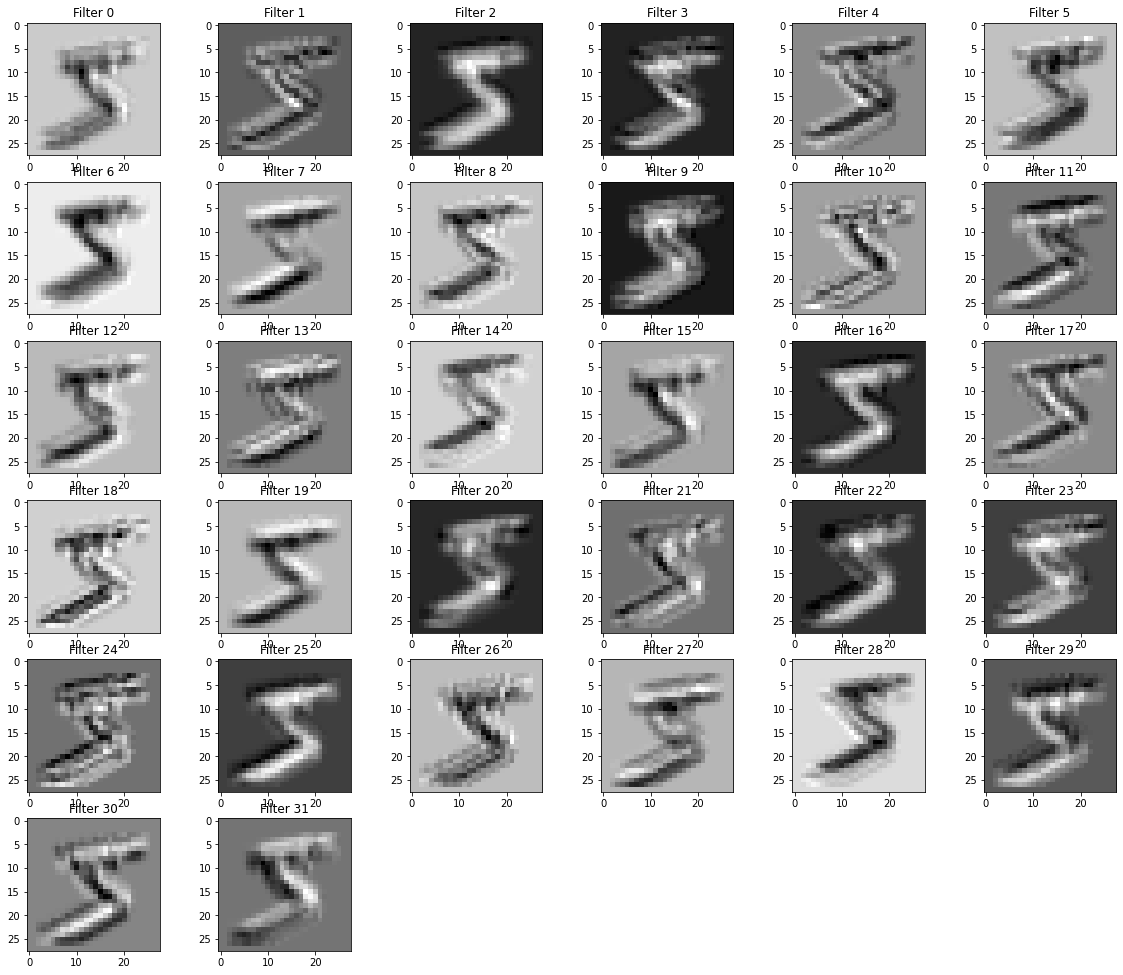

In [52]:
#ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

What about second convolution layer?


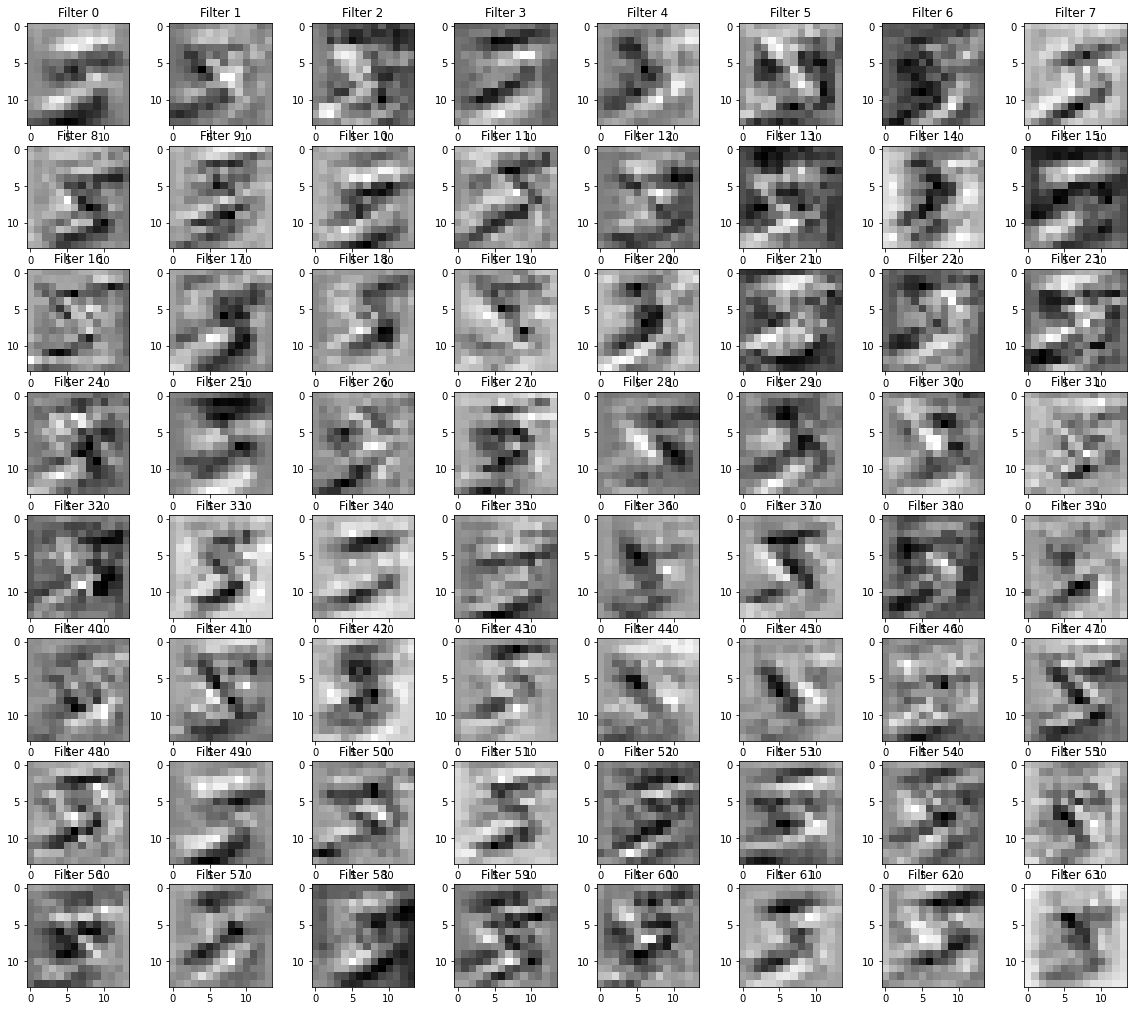

In [53]:
#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")